In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, shutil, pickle, shelve
from Bio import SeqIO
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model, Model
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling1D, Flatten, Conv1D, LSTM, CuDNNLSTM, Bidirectional
from keras.optimizers import RMSprop, Adam
from keras.initializers import glorot_normal
from utilities import sampling, one_hot_encoding, curtail, get_training_data, load_data, data_split, dianostic_plots, pad_for_detector
from utilities import get_char_list, get_freqs, get_candidates, get_motif
import keras
import utilities

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
Using TensorFlow backend.


In [3]:
# Subset sampling: save to me_samples; "me" for "mutually exclusive"
output_folder_path = "../../../../temp/buffers/me_samples"

data_dir = "/home/ubuntu/group_volume/team_neural_network/data/input/3.24_species_only"

len(os.listdir(data_dir)) # total number of regions

3543

Uncomment the following code chunk to resample training and validation data

In [7]:
# !rm -r /home/ubuntu/data/temp/train
# !mkdir /home/ubuntu/data/temp/train
# !rm -r /home/ubuntu/data/temp/val
# !mkdir /home/ubuntu/data/temp/val

# ###############################################################################
# # Sample training and validation data
# # IMPORTANT: Make sure that training and validation don't have intersection!!!
# ###############################################################################
# all_data_lst = np.array(os.listdir(data_dir))
# n = len(all_data_lst)
# num_trained_regions = int(n * 0.8)
# train_files = all_data_lst[:num_trained_regions]
# num_val = n - num_trained_regions
# val_indices = np.random.choice(np.arange(num_trained_regions, n), num_val, replace = False)
# val_files = all_data_lst[val_indices]

# train_dest = '/home/ubuntu/data/temp/train/'
# for file in train_files:
#     shutil.copy(os.path.join(data_dir, file),
#                           train_dest)
# print('copied training samples to {}'.format(train_dest))

# val_dest = '/home/ubuntu/data/temp/val/'
# for file in val_files:
#     shutil.copy(os.path.join(data_dir, file),
#                           val_dest)
# print('copied validation samples to {}'.format(val_dest))

# # Preprocess train and val data so that they are ready to be fed to models
# train_output_path = os.path.join(output_folder_path, 'train.data')
# val_output_path = os.path.join(output_folder_path, 'val.data')

# train_regions = one_hot_encoding(train_dest, train_output_path)
# val_regions = one_hot_encoding(val_dest, val_output_path)
# train_x, train_y = get_training_data(train_regions, output_folder_path,
#                                    max_len = 1000, 
#                                    train_x_name = 'train_x.data', 
#                                    train_y_name = 'train_y.data')
# val_x, val_y = get_training_data(val_regions, output_folder_path,
#                                    max_len = 1000, 
#                                    train_x_name = 'val_x.data', 
#                                    train_y_name = 'val_y.data')
# # Pad for motif detectors
# train_x, val_x = pad_for_detector(train_x, 15), pad_for_detector(val_x, 15)

copied training samples to /home/ubuntu/data/temp/train/
copied validation samples to /home/ubuntu/data/temp/val/
save to ../../../../temp/buffers/me_samples/train.data
save to ../../../../temp/buffers/me_samples/val.data
(68016, 1000, 4) (68016,)
save to ../../../../temp/buffers/me_samples/train_x.data
save to ../../../../temp/buffers/me_samples/train_y.data
(17016, 1000, 4) (17016,)
save to ../../../../temp/buffers/me_samples/val_x.data
save to ../../../../temp/buffers/me_samples/val_y.data


NameError: name 'pad_for_detector' is not defined

In [21]:
train_x = pickle.load(open(os.path.join(output_folder_path, 'train_x.data'), 'rb'))
train_y = pickle.load(open(os.path.join(output_folder_path, 'train_y.data'), 'rb'))
val_x = pickle.load(open(os.path.join(output_folder_path, 'val_x.data'), 'rb'))
val_y = pickle.load(open(os.path.join(output_folder_path, 'val_y.data'), 'rb'))

In [22]:
n = 15 # number of filters
m = 10 # filter size
train_x, val_x = pad_for_detector(train_x, m), pad_for_detector(val_x, m)

In [23]:
def get_hybrid(opt, num_filters, kernel_size):
    """  Return a hybrid network given a optimizer
    """
    model = Sequential()
    model.add(Conv1D(filters = num_filters, 
                     kernel_size = kernel_size, 
                     padding = 'valid',
                     data_format = 'channels_last',
                     activation = 'relu'))
    model.add(MaxPooling1D(pool_size = 5, strides = 5))
    model.add(Dropout(0.6))
    #model.add(Bidirectional(LSTM(20)))
    model.add(Bidirectional(CuDNNLSTM(20)))
    model.add(Dropout(0.7))
    model.add(Dense(10, activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
    return model

def train(model, train_x, train_y, val_data, config = {'epochs': 35, 'batch_size': 256}):
    """  Train model for a given config, training data, and validation data
    """
    epochs, batch_size = config['epochs'], config['batch_size']
    return model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=val_data)

In [ ]:
train_x.shape

In [27]:
# Start training
# Set up some configurations
optimizers = {'adam': Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-2, amsgrad=False),
              'rmsprop': RMSprop(lr=1e-2, rho=0.9, epsilon=None, decay=1e-2)}
config = {'epochs': 50, 'batch_size': 400}
opt = optimizers['rmsprop']

model = get_hybrid(opt, num_filters = n, kernel_size = m)
history = train(model, train_x, train_y, (val_x, val_y), config)

Train on 68016 samples, validate on 17016 samples
Epoch 1/50
68016/68016 [==============================] - 13s 195us/step - loss: 0.6801 - acc: 0.5482 - val_loss: 0.6792 - val_acc: 0.5275
Epoch 2/50
68016/68016 [==============================] - 11s 168us/step - loss: 0.6747 - acc: 0.5516 - val_loss: 0.6776 - val_acc: 0.5275
Epoch 3/50
68016/68016 [==============================] - 11s 168us/step - loss: 0.6737 - acc: 0.5519 - val_loss: 0.6801 - val_acc: 0.5275
Epoch 4/50
68016/68016 [==============================] - 11s 168us/step - loss: 0.6719 - acc: 0.5518 - val_loss: 0.6791 - val_acc: 0.5277
Epoch 5/50
68016/68016 [==============================] - 12s 170us/step - loss: 0.6714 - acc: 0.5541 - val_loss: 0.6783 - val_acc: 0.5300
Epoch 6/50
68016/68016 [==============================] - 11s 169us/step - loss: 0.6697 - acc: 0.5560 - val_loss: 0.6774 - val_acc: 0.5437
Epoch 7/50
68016/68016 [==============================] - 11s 169us/step - loss: 0.6687 - acc: 0.5550 - val_loss: 0.

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 1009, 15)          615       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 201, 15)           0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 201, 15)           0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 40)                5920      
_________________________________________________________________
dropout_26 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 10)                410       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 11        
Total para

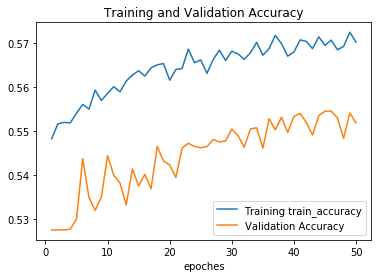

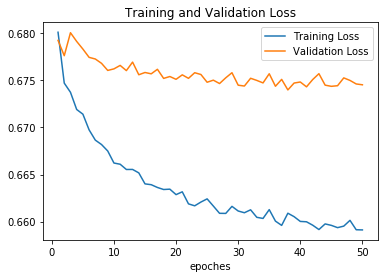

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

dianostic_plots(acc, loss, val_acc, val_loss)

In [ ]:
# Save the model for later analysis
save_model_path = '/home/ubuntu/data/team_neural_network/code/models'
model_name = 'big_hybrid_net.h5'
model.save(os.path.join(save_model_path, model_name))

In [ ]:
model = load_model('../../models/big_hybrid_net.h5')

filters = model.layers[0].get_weights()[0]
bias = model.layers[0].get_weights()[1]

In [ ]:
layer_name = model.layers[0].get_config()['name']
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(val_x)

In [ ]:
activated_subseq = get_activated_subseq(intermediate_output, val_x, m)

In [ ]:
for i in list(activated_subseq):
    char_list = get_char_list(activated_subseq[i])
    uniques, freqs = get_freqs(char_list)
    candidates = get_candidates(uniques, freqs, 0.45)
    print("*************{}**************".format(i))
    print(get_motif(candidates))
    print("*****************************\n")